# Прогноз продаж игр на следующий год

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.


## Шаг 1. Общая информация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

In [2]:
games = pd.read_csv('/datasets/games.csv')

In [3]:
display(games.head())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
games.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


### Вывод
Представленные данные изучены, видны возможные выбросы в большую сторону в столбцах с продажами, но не считаю их ошибками, т.к. они немногочисленны. Также обнаружены не совсем верный тип данных в столбцах, например, в user_score. В ряде столбцов наличествуют пропуски.

## Шаг 2. Подготовка данных

In [6]:
games.columns = games.columns.str.lower()

In [7]:
print(games.duplicated().sum())

0


In [8]:
print(games['rating'].unique())

['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']


In [9]:
games['rating'] = games['rating'].replace({'E':'6+', 'M':'17+', 'T':'13+', 'E10+':'10+', 'K-A':'6+', 'AO':'18+', 'EC':'3+', np.nan:'RP'}) # заменил значения в столбце на более понятные

In [10]:
print(games['rating'].unique())

['6+' 'RP' '17+' '13+' '10+' '18+' '3+']


In [11]:
games['sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

In [12]:
games.dropna(subset = ['year_of_release'], inplace = True)
games['year_of_release'] = games['year_of_release'].astype('int64')

In [13]:
games['user_score'] = games['user_score'].replace('tbd', np.nan)
games['user_score'] = games['user_score'].astype('float64')

In [14]:
games.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,sales
count,16446.000000,16446.000000,16446.000000,16446.000000,16446.000000,7983.000000,7463.000000,16446.000000
mean,2006.484616,0.264089,0.145945,0.078479,0.047593,68.994363,7.126330,0.536105
std,5.877050,0.818416,0.506696,0.311082,0.187994,13.920060,1.499447,1.558763
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000,6.400000,0.060000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000,7.500000,0.170000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000,8.200000,0.470000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000,9.700000,82.540000


In [15]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 12 columns):
name               16444 non-null object
platform           16446 non-null object
year_of_release    16446 non-null int64
genre              16444 non-null object
na_sales           16446 non-null float64
eu_sales           16446 non-null float64
jp_sales           16446 non-null float64
other_sales        16446 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null float64
rating             16446 non-null object
sales              16446 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


In [16]:
display(games)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,6+,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,RP,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,6+,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,6+,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,RP,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,RP,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,RP,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,RP,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,RP,0.01


### Вывод
Заменены названия столбцов, столбец user_score приведен к вещественному типу данных, т.к. это числовая оценка, значение tbd было заменено на пустое значение. Пропуски значений были оставлены, т.к. их замена окажет сильное влияние на результаты исследования. В столбце rating пропуски заменены на значение RP, что фактически является отсутствием рейтинга на данный момент. Одной из причины отсутствия оценок и рейтингов возможны в том, что игра не была оценена, либо информация об этой оценке не найдена. Посчитано суммарное значение продаж. Пропуска в столбце с годом выхода удалены, т.к. влияние на итог исследования это окажет мало

## Шаг 3. Исследовательский анализ данных

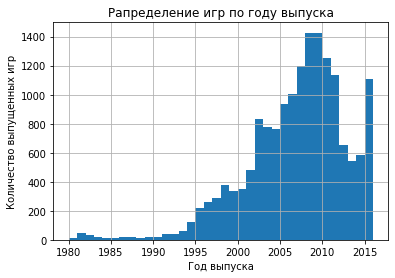

In [17]:
games['year_of_release'].hist(bins = 36)
plt.title('Рапределение игр по году выпуска')
plt.xlabel('Год выпуска')
plt.ylabel('Количество выпущенных игр')
plt.show()

### Вывод
По распределению видно что пик выхода игр приходился на 2008-2009 года, что несколько неожиданно (по моим ожиданиям количество выходящих игр с каждым годом должно расти)б возможно это связано с тем что количество платформ на которые выходит каждая игра уменьшается, что и ведет к дальнейшему сокращению. Также видно что в период с 1980 по 1995 количество выходивших игр совсем не велико, это означает что данные за этот период несут весьма мало пользы. Следубщий десятилетний период (1995-2004) хотя и характеризуется гораздо большим количеством вышедших игр, тоже вряд ли сможет пригодиться в исследовании.

<div class="alert alert-block alert-danger">
<b>КОММЕНТАРИЙ РЕВЬЮВЕРА:</b> 
    
Построй гистограмму частот по году, это правильнее и оптимальнее
    
* После опиши распределение и ответь на вопрос, какой период совсем малоинформативен?
    
</div>

<div class="alert alert-block alert-success">
<b>КОММЕНТАРИЙ РЕВЬЮВЕРА 2:</b> 
    
    
Отлично, так гораздо лучше! Думаю спад вполне может быть обусловлен тем, что на разработку стало уходить больше времени \ средств, развитие других развелечений (соц сети), мобильный гейминг

</div>

In [18]:
print(games.groupby('platform')['sales'].sum().sort_values(ascending = False).head(10))

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
Name: sales, dtype: float64


In [19]:
a = games.groupby('platform')['sales'].sum().sort_values(ascending = False).head(10).index

In [20]:
games_platform = games.query('platform in @a')

In [21]:
display(games_platform)
games_platform['platform'].unique()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,6+,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,6+,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,6+,32.77
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,6+,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,6+,28.91
...,...,...,...,...,...,...,...,...,...,...,...,...
16708,Woody Woodpecker in Crazy Castle 5,GBA,2002,Platform,0.01,0.00,0.00,0.00,NaN,NaN,RP,0.01
16709,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,0.00,0.00,0.00,0.00,NaN,NaN,RP,0.00
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,RP,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,RP,0.01


array(['Wii', 'DS', 'X360', 'PS3', 'PS2', 'GBA', 'PS4', '3DS', 'PS',
       'PSP'], dtype=object)

In [22]:
platform_pivot = games_platform.pivot_table(index = 'year_of_release', columns = 'platform', values = 'sales', aggfunc = 'sum')
display(platform_pivot)

platform,3DS,DS,GBA,PS,PS2,PS3,PS4,PSP,Wii,X360
year_of_release,,,,,,,,,,
1985,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994,NaN,NaN,NaN,6.03,NaN,NaN,NaN,NaN,NaN,NaN
1995,NaN,NaN,NaN,35.96,NaN,NaN,NaN,NaN,NaN,NaN
1996,NaN,NaN,NaN,94.70,NaN,NaN,NaN,NaN,NaN,NaN
1997,NaN,NaN,NaN,136.17,NaN,NaN,NaN,NaN,NaN,NaN
1998,NaN,NaN,NaN,169.49,NaN,NaN,NaN,NaN,NaN,NaN
1999,NaN,NaN,NaN,144.53,NaN,NaN,NaN,NaN,NaN,NaN
2000,NaN,NaN,0.07,96.37,39.17,NaN,NaN,NaN,NaN,NaN
2001,NaN,NaN,61.53,35.59,166.43,NaN,NaN,NaN,NaN,NaN


In [23]:
platform_pivot.columns

Index(['3DS', 'DS', 'GBA', 'PS', 'PS2', 'PS3', 'PS4', 'PSP', 'Wii', 'X360'], dtype='object', name='platform')

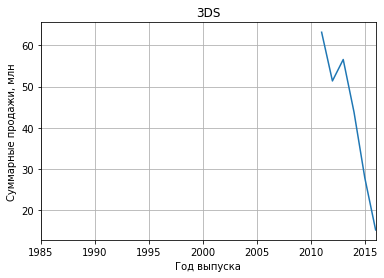

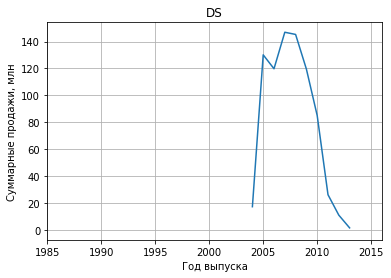

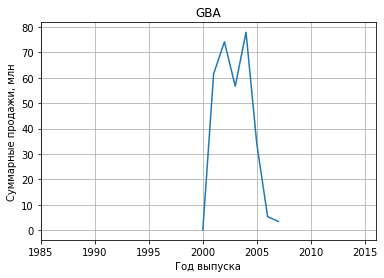

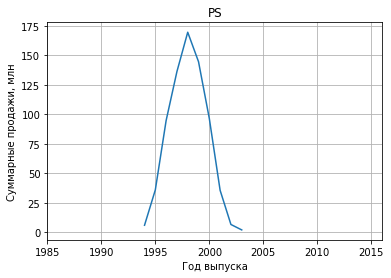

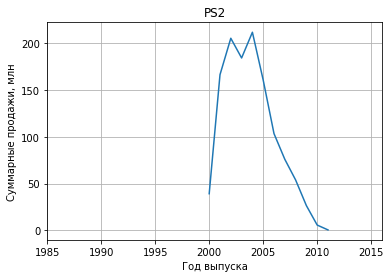

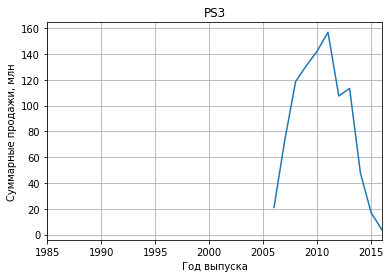

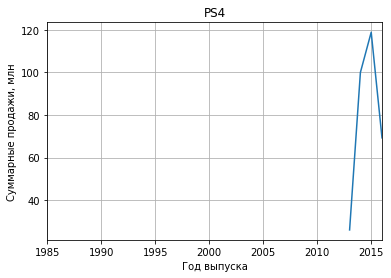

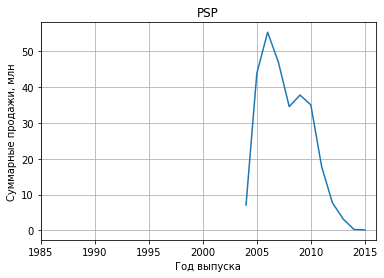

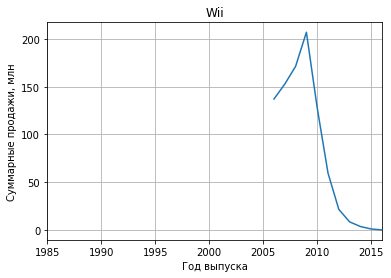

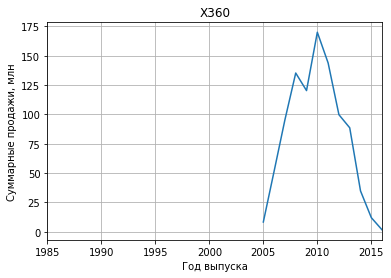

In [24]:
for i in platform_pivot.columns:
    platform_pivot[i].plot(grid = True)
    plt.title(i)
    plt.xlabel('Год выпуска')
    plt.ylabel('Суммарные продажи, млн')
    plt.show()

### Вывод
Данные за весь период не помогут провести правильное исследование, поэтому необходимо использовать данные за последние несколько лет, при изучении графиков видно, что средний срок жизни платформы примерно равен 10 годам. Примем средний актуальный период за последние 5 лет

In [27]:
data_pred_platform =  data_pred.pivot_table(index = 'year_of_release', columns = 'platform', values = 'sales', aggfunc = 'sum')

In [28]:
display(data_pred_platform)

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


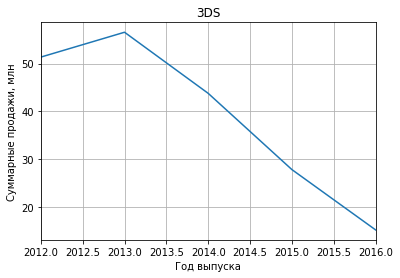

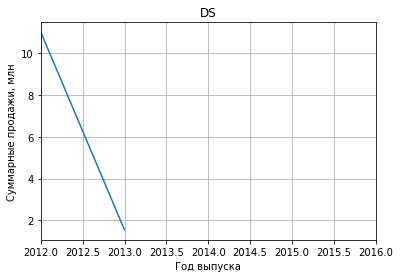

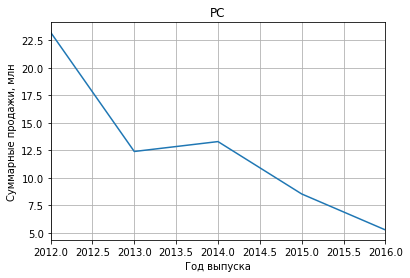

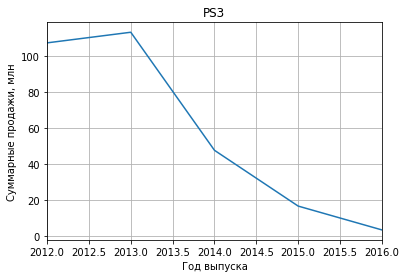

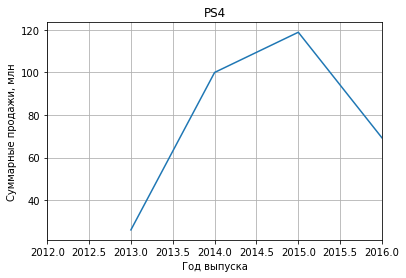

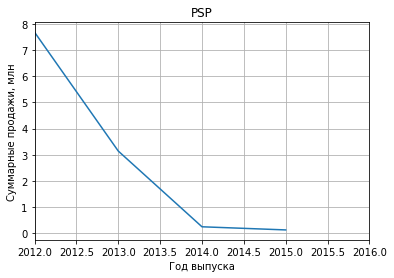

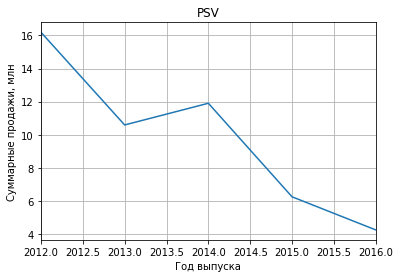

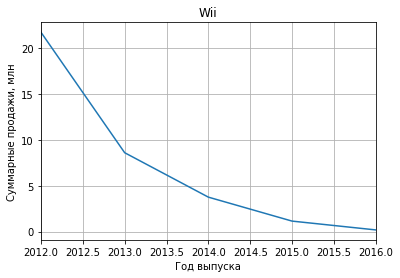

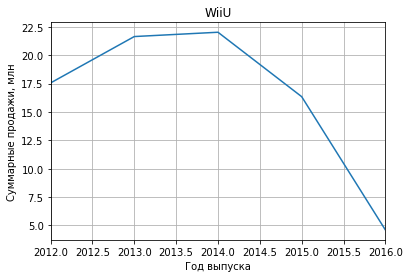

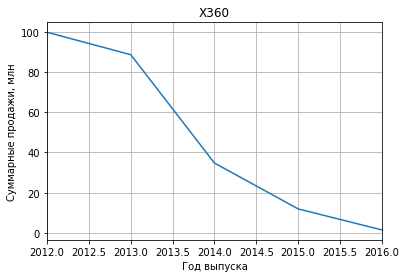

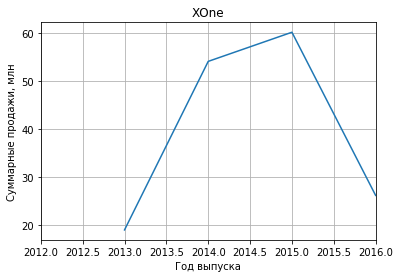

In [29]:
for i in data_pred_platform.columns:
    data_pred_platform[i].plot(grid = True)
    plt.title(i)
    plt.xlabel('Год выпуска')
    plt.ylabel('Суммарные продажи, млн')
    plt.show()

### Вывод
Платформы DS, PSP нет смысла учитывать, т.к. их продажи прекратились раньше 2016 года. Примем за перспективные все платформы, продажи на которых велись в 2016 году

In [30]:
pers_plat = ['3DS', 'PC', 'PS3', 'PS4', 'PSV', 'Wii', 'WiiU', 'X360', 'XOne']
data = data_pred.query('platform in @pers_plat')

In [31]:
display(data)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,17+,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,17+,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,RP,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,RP,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,17+,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,RP,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,RP,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,RP,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,RP,0.01


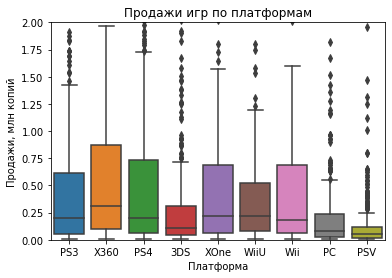

In [32]:
sns.boxplot(x = 'platform', y = 'sales', data = data).set(ylim = (0,2))
plt.title('Продажи игр по платформам')
plt.xlabel('Платформа')
plt.ylabel('Продажи, млн копий')
plt.show()

### Вывод
По результатам анализа видно, что медианные значения платформ Wii, Xbox, PS примерно равны и превосходят значения для остальных плафторм. В то же время 3 квартиль у Xbox и PS выше аналогичного у Wii. Это означает что игры, продаваемые выше среднего для первых двух в среднем приносят больше дохода. 

In [33]:
def score(platform):
    data.query('platform == platform').pivot_table(index = 'user_score', values = 'sales').reset_index().plot(grid = True, x = 'user_score', y = 'sales', kind = 'scatter')
    plt.ylabel = ('Продажи, млн копий')
    plt.xlabel = ('Рейтинг пользователей')
    plt.title = ('Влияние пользовательского рейтинга для платформы' + platform)

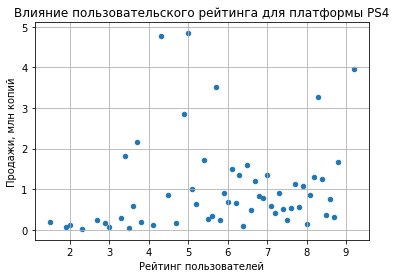

In [34]:
data.query('platform == "PS4"').pivot_table(index = 'user_score', values = 'sales').reset_index().plot(grid = True, x = 'user_score', y = 'sales', kind = 'scatter')
plt.ylabel('Продажи, млн копий')
plt.xlabel('Рейтинг пользователей')
plt.title('Влияние пользовательского рейтинга для платформы PS4')
plt.show()

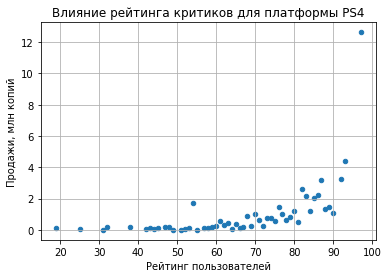

In [35]:
data.query('platform == "PS4"').pivot_table(index = 'critic_score', values = 'sales').reset_index().plot(grid = True, x = 'critic_score', y = 'sales', kind = 'scatter')
plt.ylabel('Продажи, млн копий')
plt.xlabel('Рейтинг пользователей')
plt.title('Влияние рейтинга критиков для платформы PS4')
plt.show()

In [36]:
print('коэффициент корреляции для рейтинга критиков =', data.query('platform == "PS4"')['sales'].corr(data.query('platform == "PS4"')['critic_score']))
print('коэффициент корреляции для рейтинга пользователей =', data.query('platform == "PS4"')['sales'].corr(data.query('platform == "PS4"')['user_score']))

коэффициент корреляции для рейтинга критиков = 0.406567902061781
коэффициент корреляции для рейтинга пользователей = -0.031957110204556424


### Вывод
По полученным графикам для платормы PS4 можно судить о том что пользовательский рейтинг практически не оказывает влияния на продажи, как и рейтинг критиков при значениях до 60, после превышения этого значения наблюдается тренд на увеличение продаж при повышении рейтинга.

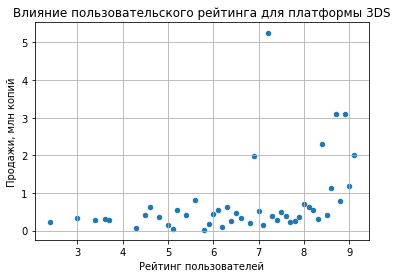

коэффициент корреляции = 0.19758263411038596


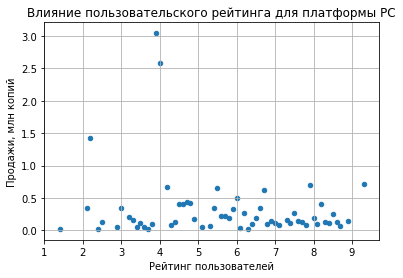

коэффициент корреляции = -0.12186747630735577


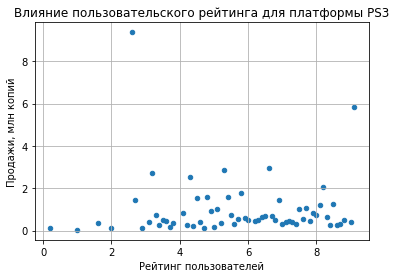

коэффициент корреляции = -0.005143522887113816


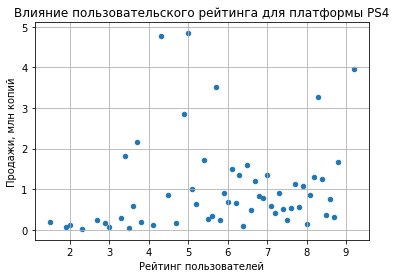

коэффициент корреляции = -0.031957110204556424


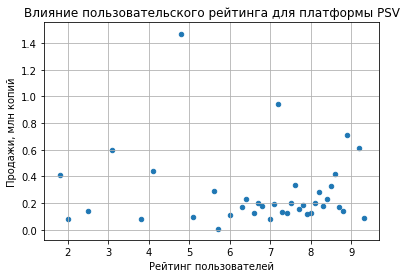

коэффициент корреляции = -0.004339437514314869


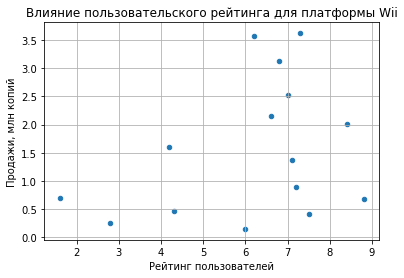

коэффициент корреляции = 0.2961968000747953


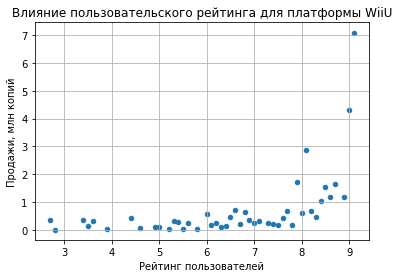

коэффициент корреляции = 0.4002190202148617


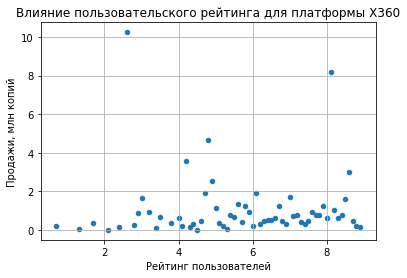

коэффициент корреляции = 0.0061639786462133256


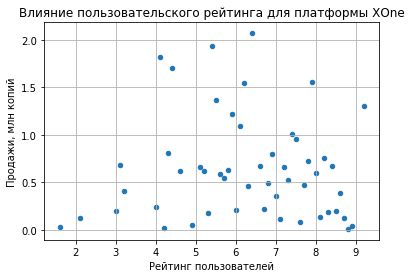

коэффициент корреляции = -0.06892505328279412


In [37]:
for t in pers_plat:    
    data.query('platform == @t').pivot_table(index = 'user_score', values = 'sales').reset_index().plot(grid = True, x = 'user_score', y = 'sales', kind = 'scatter')
    plt.ylabel('Продажи, млн копий')
    plt.xlabel('Рейтинг пользователей')
    plt.title('Влияние пользовательского рейтинга для платформы ' +t)
    plt.show()
    print('коэффициент корреляции =', data.query('platform == @t')['sales'].corr(data.query('platform == @t')['user_score']))

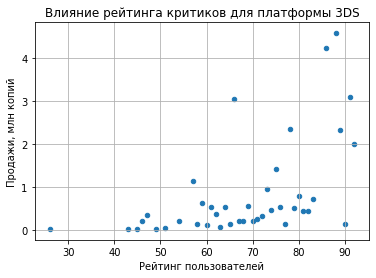

коэффициент корреляции = 0.32080286953607845


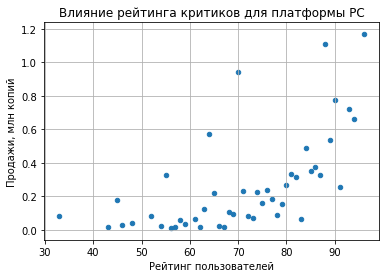

коэффициент корреляции = 0.23724324311567918


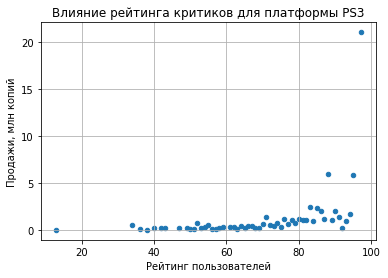

коэффициент корреляции = 0.3314972592629587


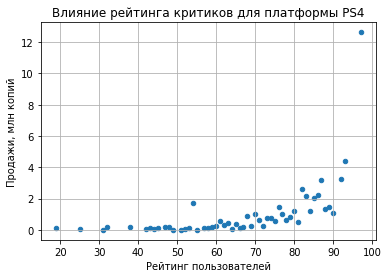

коэффициент корреляции = 0.406567902061781


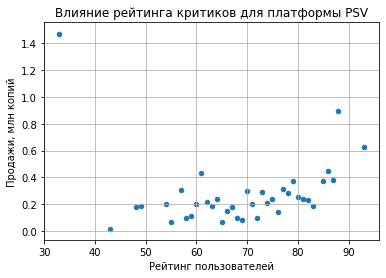

коэффициент корреляции = 0.09448789929316172


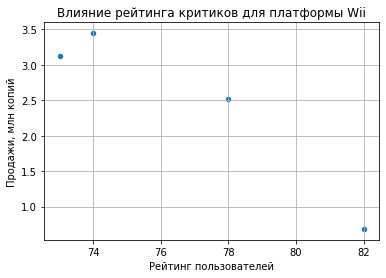

коэффициент корреляции = -0.4243413011077495


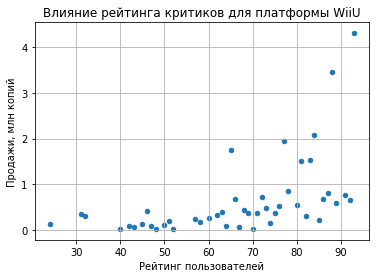

коэффициент корреляции = 0.3483797601201749


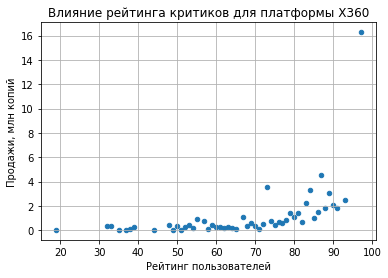

коэффициент корреляции = 0.36057348885073365


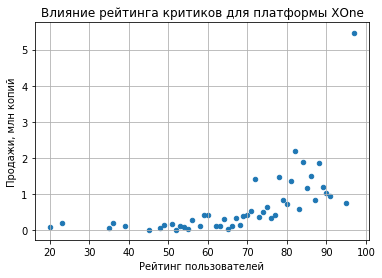

коэффициент корреляции = 0.41699832800840175


In [38]:
for t in pers_plat:    
    data.query('platform == @t').pivot_table(index = 'critic_score', values = 'sales').reset_index().plot(grid = True, x = 'critic_score', y = 'sales', kind = 'scatter')
    plt.ylabel('Продажи, млн копий')
    plt.xlabel('Рейтинг пользователей')
    plt.title('Влияние рейтинга критиков для платформы ' +t)
    plt.show()
    print('коэффициент корреляции =', data.query('platform == @t')['sales'].corr(data.query('platform == @t')['critic_score']))

### Вывод
При анализе зависимости для других платформ, можно сказать что корреляция продаж с оценкой критиков аналогична корреляции для PS4, корреляция продаж с оценкой пользователей также незначительна, за исключением платформ 3DS, Wii, WiiU, где наблюдается корреляция схожая с корреляцией по оценце критиков.

In [39]:
print(data.groupby('genre')['sales'].sum().sort_values(ascending = False))

genre
Action          435.54
Shooter         304.73
Role-Playing    180.91
Sports          179.55
Misc             84.15
Platform         60.31
Racing           53.50
Fighting         44.13
Simulation       34.85
Adventure        27.70
Strategy         12.63
Puzzle            4.79
Name: sales, dtype: float64


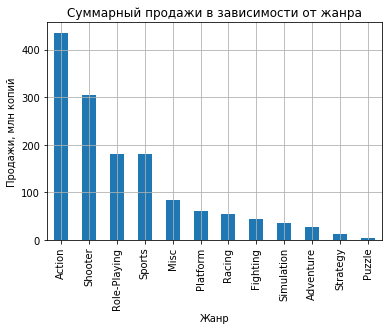

In [40]:
data.groupby('genre')['sales'].sum().sort_values(ascending = False).plot(kind = 'bar', grid = True)
plt.title('Суммарный продажи в зависимости от жанра')
plt.xlabel('Жанр')
plt.ylabel('Продажи, млн копий')
plt.show()

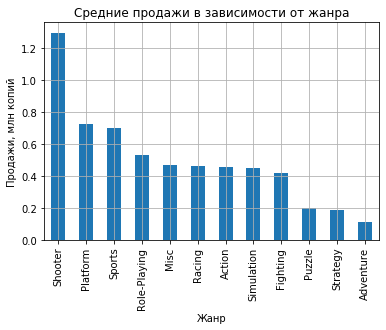

In [41]:
data.groupby('genre')['sales'].mean().sort_values(ascending = False).plot(kind = 'bar', grid = True)
plt.title('Средние продажи в зависимости от жанра')
plt.xlabel('Жанр')
plt.ylabel('Продажи, млн копий')
plt.show()

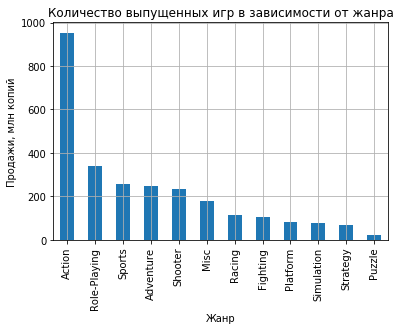

In [42]:
data.groupby('genre')['sales'].count().sort_values(ascending = False).plot(kind = 'bar', grid = True)
plt.title('Количество выпущенных игр в зависимости от жанра')
plt.xlabel('Жанр')
plt.ylabel('Продажи, млн копий')
plt.show()

### Вывод
При анализе суммарных продаж по жанру можно судить о высоких продажах для жанров Action и Shooter. Второй жанр можно рассматривать как подтип первого, так что очевидным становится то, что самыми продаваемыми являются игры, требующие от пользователя высокой активности. Также в подтверждение этому идет, то что самые малопродаваемые игры жанров puzzle, strategy, adventure.

При рассмотрении по количеству выпущенных игр и среднему по продаже на игру можно увидеть различные стороны суммарных продаж, например жанр Action только 7 по средним продажам, но по количеству выпущенных игр превосходит идущий за ним жанр Role-Playing почти в 3 раза. По средним продажам лидирующие позиции занимает жанр shooter, хотя по количеству игр он только 5. Средние продажи платформеров весьма высоки, но количество выпускаемых игр при этом весьма мало. Примечательно, что игры жанра Adventure, занимают последнее место по средним продажам, но количество выпускаемых игр даже превышает показатели шутеров, являющимся лидером по первому показателю.

### Шаг 4. Портрет пользователя каждого региона

In [43]:
print(data.groupby('platform')['na_sales'].sum().sort_values(ascending = False).head(5))
print(data.groupby('platform')['na_sales'].sum().sort_values(ascending = False).head(5)
      / data.groupby('platform')['na_sales'].sum().sort_values(ascending = False).head(5).sum())

platform
X360    140.05
PS4     108.74
PS3     103.38
XOne     93.12
3DS      55.31
Name: na_sales, dtype: float64
platform
X360    0.279764
PS4     0.217219
PS3     0.206512
XOne    0.186017
3DS     0.110487
Name: na_sales, dtype: float64


In [44]:
print(data.groupby('platform')['eu_sales'].sum().sort_values(ascending = False).head(5))
print(data.groupby('platform')['eu_sales'].sum().sort_values(ascending = False).head(5)
      / data.groupby('platform')['eu_sales'].sum().sort_values(ascending = False).head(5).sum())

platform
PS4     141.09
PS3     106.86
X360     74.52
XOne     51.59
3DS      42.64
Name: eu_sales, dtype: float64
platform
PS4     0.338589
PS3     0.256443
X360    0.178834
XOne    0.123806
3DS     0.102328
Name: eu_sales, dtype: float64


In [45]:
print(data.groupby('platform')['jp_sales'].sum().sort_values(ascending = False).head(5))
print(data.groupby('platform')['jp_sales'].sum().sort_values(ascending = False).head(5)
      / data.groupby('platform')['jp_sales'].sum().sort_values(ascending = False).head(5).sum())

platform
3DS     87.79
PS3     35.29
PSV     21.04
PS4     15.96
WiiU    13.01
Name: jp_sales, dtype: float64
platform
3DS     0.507193
PS3     0.203882
PSV     0.121555
PS4     0.092206
WiiU    0.075163
Name: jp_sales, dtype: float64


### Вывод
При анализе по региональному использованию платформ заметны определенные сходства между североамериканскими и европейскими пользователями. По долям использования заметно что в СА доля пользователей, использующих xbox немного превышает долю испотльзующих PS, причем при сравнении платформ нового поколения ситуация обратная, возможно это связано с тем что пользователи медленно переходят Xbox медленне переходят на новое поколение, либо меняют свою платформу. В европе же наблюдается ситуация, когда доля пользователей PS почти в 2 раза превышает долю пользователей Xbox. Предпочтения японских пользователей отличаются, заметно что более половины составляют продажи игр для портативных консолей(3DS, WiiU) в то время как для остальных пользователей только 3DS входит в топ-5, причем уступая даже отдельным представителям платформ PS и Xbox, вторыми по популярности ожидаемо являются PS.

In [46]:
print(data_pred.groupby('genre')['na_sales'].sum().sort_values(ascending = False).head(5))

genre
Action          177.84
Shooter         144.77
Sports           81.53
Role-Playing     64.00
Misc             38.19
Name: na_sales, dtype: float64


In [47]:
print(data_pred.groupby('genre')['eu_sales'].sum().sort_values(ascending = False).head(5))

genre
Action          159.34
Shooter         113.47
Sports           69.09
Role-Playing     48.53
Racing           27.29
Name: eu_sales, dtype: float64


In [48]:
print(data_pred.groupby('genre')['jp_sales'].sum().sort_values(ascending = False).head(5))

genre
Role-Playing    65.44
Action          52.80
Misc            12.86
Simulation      10.41
Fighting         9.44
Name: jp_sales, dtype: float64


### Вывод
При рассмотрении распределения по популярности жанров также замечается сходство североамериканского и европейского пользователя, топ-5 для которых совпадает. Для японских пользователей ситуация отлчиается, на первое место выходит жанр Role-playing, вероятно что это игры специфического для Японских игр жанра JRPG, так же примечательно отсутствие жанра Shooting и присутствие симуляторов и файтингов.

In [49]:
def sales_pivot(values):
    data_pred.pivot_table(index = 'rating', values = values, aggfunc = 'sum').reset_index().plot(grid = True, x = 'rating', y = values, kind = 'bar')
    plt.title('Распределение продаж по возрастному рейтингу')
    plt.xlabel('Возрастной рейтинг')
    plt.ylabel('Продажи, млн копий')
    plt.show()

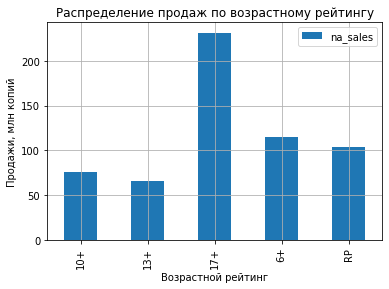

In [50]:
sales_pivot('na_sales')

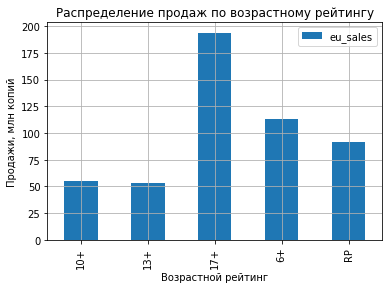

In [51]:
sales_pivot('eu_sales')

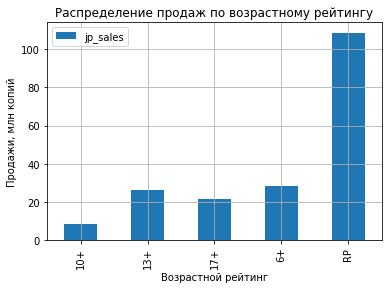

In [52]:
sales_pivot('jp_sales')

### Вывод
В очередной раз заметно сходство американских и европейских пользователей, доли продаж для каждого рейтинга там примерно одинаковые. Самые продаваемые игры в категории 17+, второй по популярности является категория 6+, что возможно включает в себя различные игры для детей. Для японских пользователей заметно, что более половины продаж приходятся на не имеющие данный рейтинг игры. Возможно это связано с тем, что рейтинг ESRB выдается для Северной Америки, а как видно из распределения продаж по жанрам для японских пользователей, игры, покупаемые ими отличаются и вполне вероятно могут быть предназначены для японского рынка.Еще одним фактором является  полное отсутствие продаж в категории 18+ и 3+. Это связано с тем, что категория 3+ существует только как игры для самых маленьких детей и вероятно их немного и продажи у них не высокие. Игры с рейтингом 18+ отсутствуют, т.к. по моему мнению производители делают все возможное чтобы игра не присвоили данный рейтинг, т.к. продажи данных игр весьма затруднены.

### Шаг 5. Проверка гипотез

In [53]:
def stat(data, column):
    mean = data[column].mean()
    print('среднее', mean)
    variance = np.var(data[column])
    print('дисперсия =', variance)
    standard_dev = np.std(data[column], ddof = 1)
    print('стандартное отклонение =', standard_dev)
    data[column].hist(bins = 20)

среднее 6.521428571428572
дисперсия = 1.8965188383045526
стандартное отклонение = 1.380940564592144


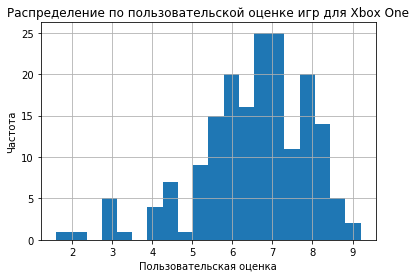

In [54]:
stat(data.query('platform == "XOne"'), 'user_score')
plt.title('Распределение по пользовательской оценке игр для Xbox One')
plt.xlabel('Пользовательская оценка')
plt.ylabel('Частота')
plt.show()

среднее 6.428640776699029
дисперсия = 2.7569952398906588
стандартное отклонение = 1.6644650783835682


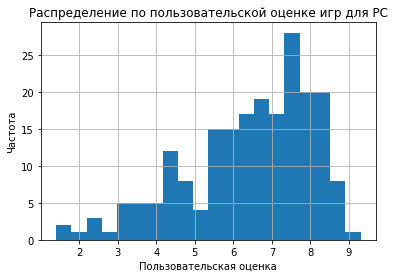

In [55]:
stat(data.query('platform == "PC"'), 'user_score')
plt.title('Распределение по пользовательской оценке игр для PC')
plt.xlabel('Пользовательская оценка')
plt.ylabel('Частота')
plt.show()

In [65]:
alpha =.05
statist, pvalue = st.mannwhitneyu(data.query('platform == "PC"')['user_score'], data.query('platform == "XOne"')['user_score'], alternative = 'two-sided')
print('p-значение:', pvalue)
if (pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.11985653983699557
Не получилось отвергнуть нулевую гипотезу


среднее 6.8336538461538465
дисперсия = 1.860463572485207
стандартное отклонение = 1.3653015347231379


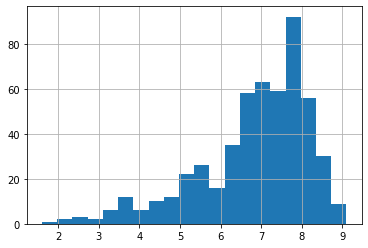

In [57]:
stat(data.query('genre == "Action"'), 'user_score')

среднее 5.466494845360825
дисперсия = 3.0009908066744604
стандартное отклонение = 1.7368189260364986


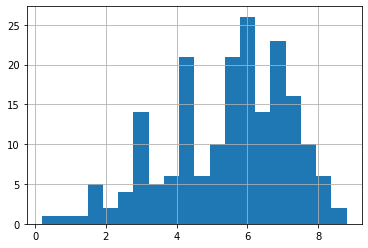

In [58]:
stat(data.query('genre == "Sports"'), 'user_score')

In [74]:
alpha =.05
statist, pvalue = st.mannwhitneyu(data.query('genre == "Sports"')['user_score'], data.query('genre == "Action"')['user_score'], alternative = 'two-sided')
print('p-значение:', pvalue)
if (pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 6.196890159460559e-21
Отвергаем нулевую гипотезу


### Проверка по t-критерию Стьюдента

In [76]:
data_2 = data.dropna(subset =['user_score'])# t-тест не работает с пропущенными значениями

среднее 5.466494845360825
дисперсия = 3.0009908066744604
стандартное отклонение = 1.7368189260364986
среднее 5.466494845360825
дисперсия = 3.0009908066744604
стандартное отклонение = 1.7368189260364986


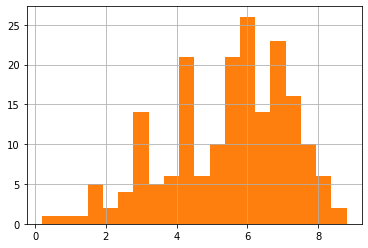

In [83]:
stat(data_2.query('genre == "Sports"'), 'user_score')
stat(data.query('genre == "Sports"'), 'user_score') # показано что распределения одинаковые

In [93]:
variance = np.var(data_2.query('platform == "PC"')['user_score'])
print('дисперсия =', variance)
variance_2 = np.var(data_2.query('platform == "XOne"')['user_score'])
print('дисперсия =', variance_2)

дисперсия = 2.7569952398906588
дисперсия = 1.8965188383045526


In [94]:
variance = np.var(data_2.query('genre == "Sports"')['user_score'])
print('дисперсия =', variance)
variance_2 = np.var(data_2.query('genre == "Action"')['user_score'])
print('дисперсия =', variance_2)

дисперсия = 3.0009908066744604
дисперсия = 1.8604635724852072


### Вывод
Так как, дисперсии отличаются, то параметр Equal_var = False

In [95]:
alpha =.05
equel_var = False
results = st.ttest_ind(data_2.query('platform == "PC"')['user_score'], data_2.query('platform == "XOne"')['user_score'], equal_var = False)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5535080500643661
Не получилось отвергнуть нулевую гипотезу


In [96]:
alpha =.05
equel_var = False
results = st.ttest_ind(data_2.query('genre == "Sports"')['user_score'], data_2.query('genre == "Action"')['user_score'], equal_var = False)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.1613574354387965e-20
Отвергаем нулевую гипотезу


### Вывод
Нулевые гипотезы: 

1.Средние пользовательские оценки для Xbox One равно средним пользовательским оценкам для PC

2.Средние пользовательские оценки для жанра Action равно средним пользовательским оценкам для жанра Sports

Альтернативные гипотезы:

1.Средние пользовательские оценки для Xbox One не равны средним пользовательским оценкам для PC

2.Средние пользовательские оценки для жанра Action не равны средним пользовательским оценкам для жанра Sports


Для проверки данных гипотез использовался критерий Манна — Уитни, т.к. обе выборки не представляют из себя нормального распредения.
Интуитивно представлялось, что в первом случае нулевая гипотеза верна, а во втором нет, что и подтвердилось при проверке гипотезы.
При проверке по t-критерию Стьюдента результаты проверки оказались аналогичными.

## Шаг 6. Вывод

По результату анализа можно сделать вывод о том, что подход к продажам для европейских и американских пользователей отличается от подхода к японским по многочисленным параметрам. Считаю, что наиболее перспективными для продажи в 2017 году будут игры на платформах PS 4 и Xbox One, в жанрах action, shooting и sports для западных пользователей и игры на платформах 3DS, PS4 в жанре role-playing для японских пользователей. При проверке зависимостей от оценок пользователей и критиков, можно наблюдать неоторую положительную корреляцию продаж с оценками критиков, а в случае с портативными консолями и с оценками пользователей. При проверке заданных гипотез в задании удалось подтвердить, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые, а средние пользовательские рейтинги жанров Action и Sports разные.